In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.sparse as sp
import scipy.cluster.hierarchy as spc


from collections import Counter
from glob import glob
from matplotlib import cm
from matplotlib.patches import Rectangle
from scipy.stats import zscore
from scipy.spatial.distance import pdist
from sklearn.manifold import MDS
from sklearn.preprocessing import normalize
from statsmodels.stats.multitest import multipletests

# 1. Descriptives

In this section, we examine the overall distribution of analytic method mentions across domains and journals.

## 1.1 Initialize and Preprocess

In [8]:
from analysis_main.ents_base import EntityBase
ent_classification = pd.read_csv('analysis_main/ent_classification.csv')
ent_classification_l1 = ent_classification.loc[~ent_classification.classification.isna(), :].copy()
ent_grouper_l1 = {ent: group for ent, group in 
                  zip(ent_classification['ents'], ent_classification['classification'])}
ent_base = EntityBase('results/ents/article_ents_final.pickle', ent_grouper_l1, 
                      year_range=(2008, 2021))
df, additional_df = ent_base.convert_to_dataframe(['domain', 'year', 'date', 'journal'])

## 1.2. Domain Embeddings

Using the analytic method count vector (i.e. counts across each analytic method entity) of each domain, we compared the overall similarity in analytic method mentions across domains using a multidimensional scaling approach.

### 1.2.1. Compute Entity by Domain Count Matrix

In [4]:
ent_by_domain = df.groupby(additional_df['domain']).sum()
domain_count = additional_df.groupby('domain').size()
domains = list(ent_by_domain.index)

### 1.2.2 Compute MDS embedding and visualize

In [5]:
embedding = MDS().fit_transform(zscore(ent_by_domain.values.T).T)

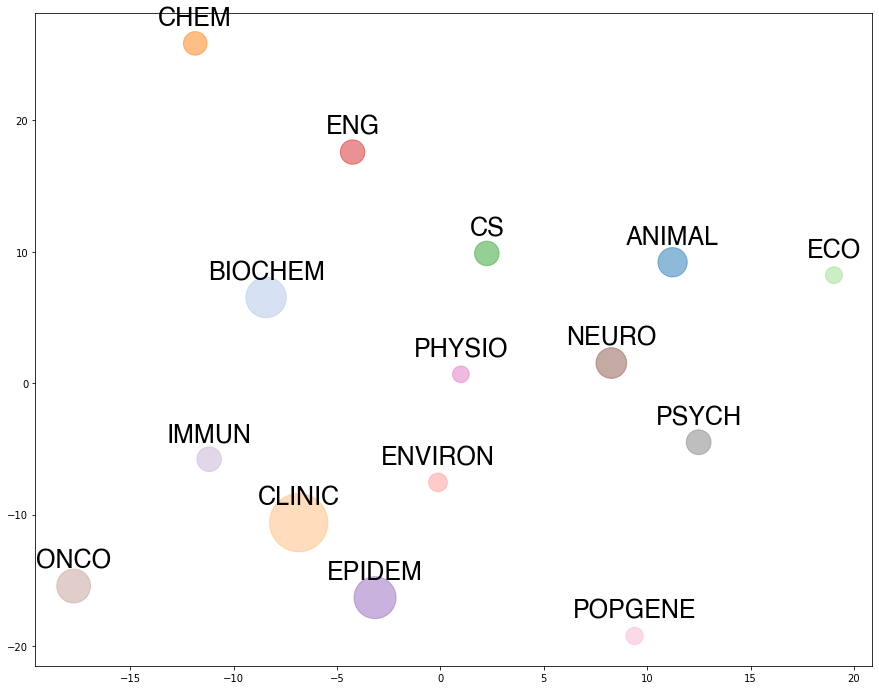

In [6]:
cmap = cm.tab20  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(embedding[:,0], embedding[:,1], s=domain_count/100, color=cmaplist[:15], cmap=cmap, alpha=0.5)
# plt.ylim([-20, 20])
# plt.xlim([-15, 16])
# zip joins x and y coordinates in pairs
for x, y, domain in zip(embedding[:,0], embedding[:,1], domains):
    
    label = "{:.2f}".format(y)
    # this method is called for each point
    ax.annotate(domain, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,18), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 size=25, weight='bold', fontname='Helvetica') 
plt.savefig('/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure2/Domain_Embedding.png')

## 1.3. Journal Counts by Domain

### 1.3.1 Get Top Journal Counts

In [11]:
domain_by_journal = additional_df['domain'].groupby([additional_df['journal'], additional_df['domain']]).size()
journal_by_domain = additional_df['journal'].groupby([additional_df['domain'], additional_df['journal']]).size()

journal_top_by_domain = journal_by_domain.groupby('journal').apply(lambda x: x.sort_values(ascending=False)[:10])

### 1.3.2 Visualize

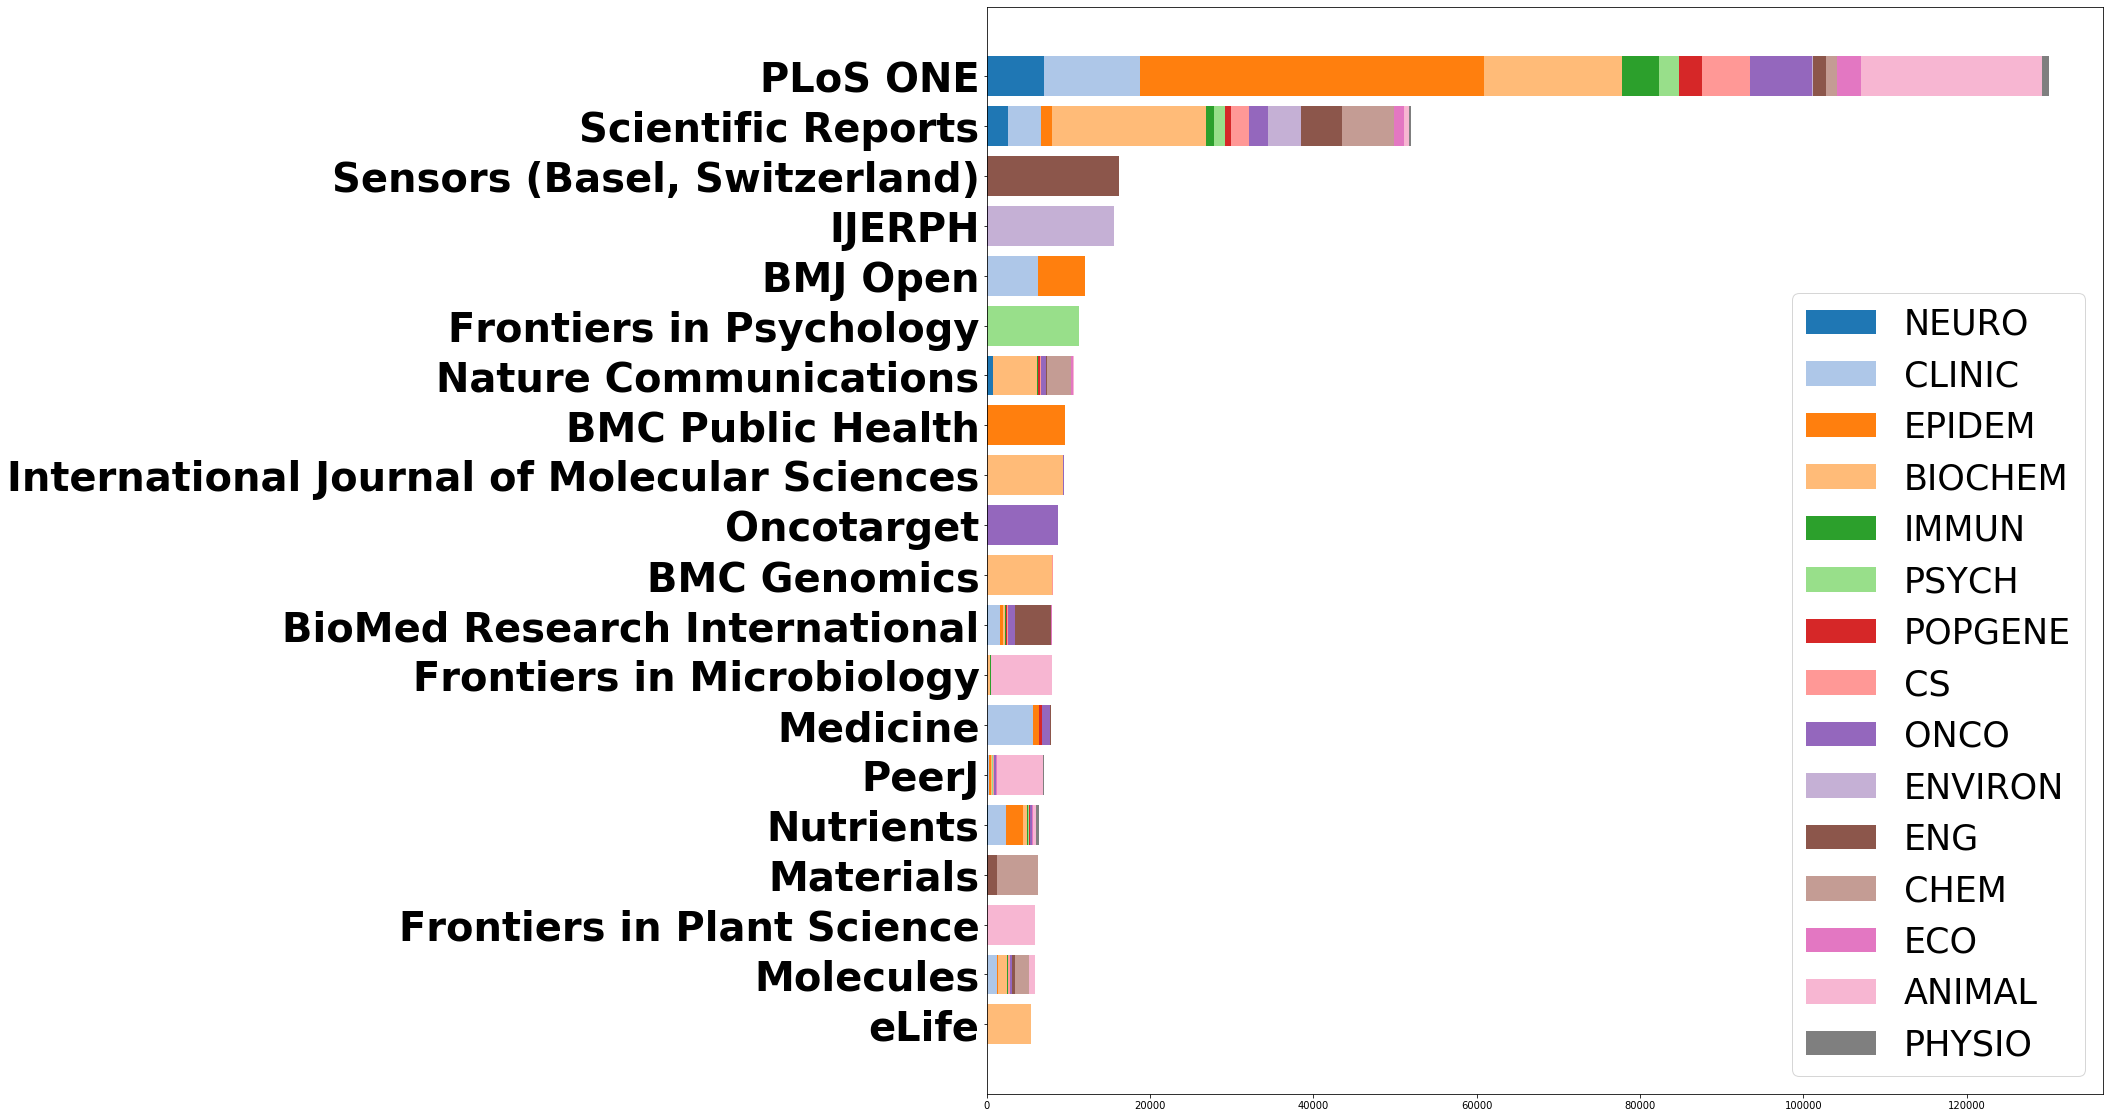

In [13]:
journals = additional_df['journal'].value_counts().sort_values(ascending=False)[:20].index
domains = additional_df['domain'].unique()

journal_domain_counts = []
for journal in journals:
    domain_counts = domain_by_journal.loc[journal].to_dict()
    all_domain_counts = [domain_counts[domain] if domain in domain_counts else 0 for domain in domains]
    all_domain_counts_perc = [domain for domain in all_domain_counts]
    journal_domain_counts.append(all_domain_counts_perc)

journal_domain_counts = np.array(journal_domain_counts)
fig, ax = plt.subplots(figsize=(20,20))
ypos = np.arange(len(journals))
cmap = cm.tab20  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
for indx, domain, color in zip(range(len(domains)), domains, cmaplist):
    bottom=journal_domain_counts[:,:indx].sum(axis=1)
    ax.barh(ypos, journal_domain_counts[:,indx], left=bottom, color=color, label=domain)
ax.set_yticks(ypos)
new_journal_names = ['IJERPH' if 'International Journal of Environmental' in journal
                     else journal 
                     for journal in journals]
ax.set_yticklabels(new_journal_names, fontweight='bold', fontsize=40)
ax.invert_yaxis()  # labels read top-to-bottom
# plt.xlim(0,1.5)
plt.legend(fontsize=35)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure2/Journal_Counts.png', bbox_inches='tight')

## 1.4. Top Entities

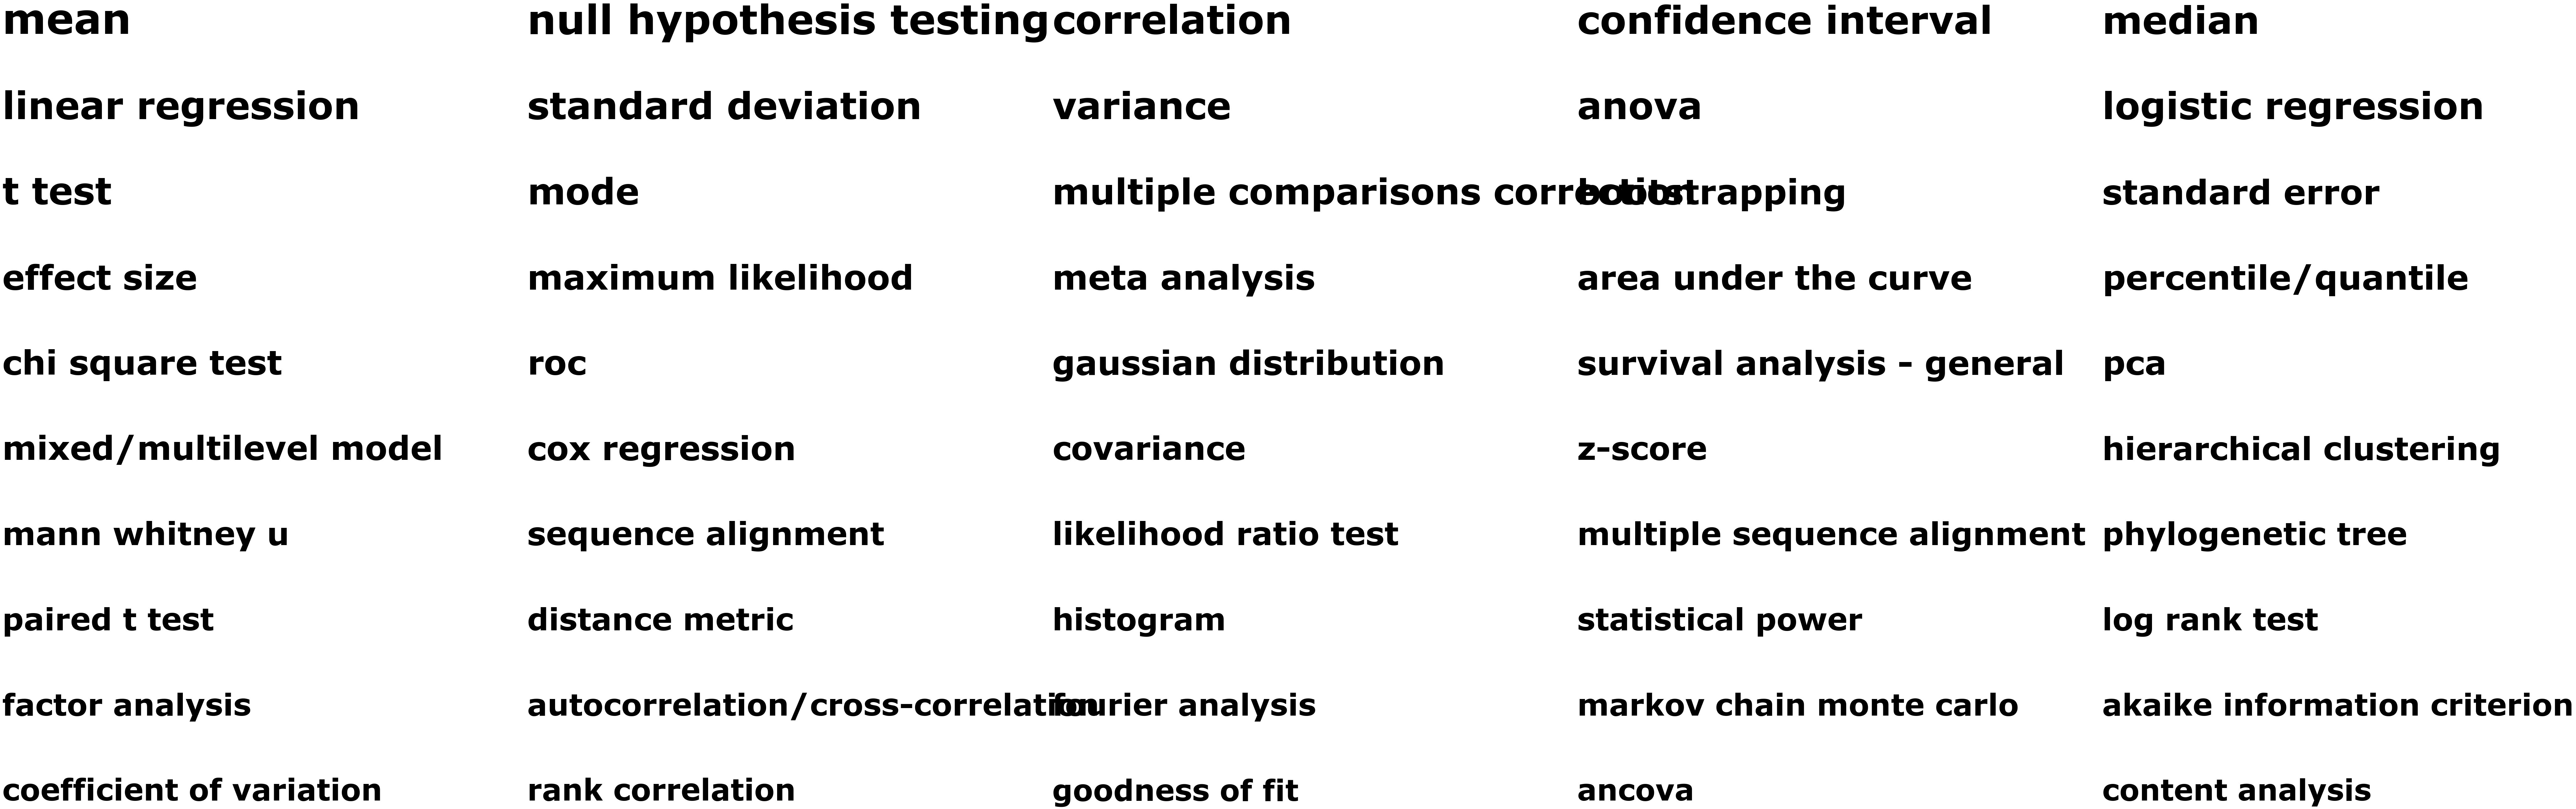

In [20]:
y_list = [num for num in range(10) for y in range(5)][::-1]
x_list = [x for num in range(10) for x in range(5)]
ent_sums = df.sum(axis=0).sort_values(ascending=False)[:50]
fig, ax = plt.subplots(figsize=(30,5))
for i, (ent, count) in enumerate(ent_sums.iteritems()):
    size = count
    x = x_list[i]
    y = y_list[i]
    if len(ent) > 15 len(ent.strip()) > 1:
        
    ax.text(x, y, ent, fontsize=np.log(size)*10, fontweight='bold', family='Verdana')
fig.patch.set_visible(False)
ax.axis('off')
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure2/Entity_Counts.png', bbox_inches='tight')

# 2. Entity Trends

In this section, we examine the fluctations in 'analytic method categories' on a yearly time scale from the beginning of 2009 to the end of 2020. Analytic method categories were constructed as larger groups of analytic method entities that share a common mathematical and/or conceptual framework (e.g. anova/t-test, survival analysis, etc.). The 'statistical significance' of the linear trend of each analytic method category was assessed using a regression model.

## 2.1. Initialize and Preprocess 

* As described in the paper, we use the manually classified method *categories* for examining entity trends

In [2]:
from analysis_main.ents_trends import EntityTrends
ent_classification = pd.read_csv('analysis_main/ent_classification.csv')
ent_classification_l2 = ent_classification.loc[~ent_classification.classification2.isna(), :].copy()
ent_grouper_l2 = {ent: group for ent, group in 
                  zip(ent_classification_l2['ents'], ent_classification_l2['classification2'])}
ent_trends = EntityTrends('results/ents/article_ents_final.pickle', 
                      ent_grouper=ent_grouper_l2, 
                      year_range=(2009, 2020))
df, additional_df = ent_trends.convert_to_dataframe(['domain', 'year', 'date', 'journal'])
df_analysis = pd.concat([df, additional_df], axis=1)
df_analysis.columns = [col.replace('-','_').replace(' ', '_').replace('/', '_')
                       for col in df_analysis.columns]
del df, additional_df


## 2.2 Run Marginal Models to test for linear trend and interactions

### 2.2.1 Estimate Models (Option 1)

* Model - logit model estimating the log-odds of an entity category (e.g. 'anova/t-test) occuring in an article's method/results section conditional on the year and scientific domain (e.g. psychology) of that article. The model is estimated using generalized estimating equations accounting for the nested structure of articles within a journal (N=17,847). Of interest is the estimation of the linear yearly trend of the log-odds of an entity categories' occurence in an article over our timeframe (2009-2020), and whether this linear trend differs by domain (i.e. the interaction - year * domain).

* We estimate a separate model for each entity category, so this can take a while ~1hr on my desktop. We provide a pre-run model pickle file in the 'analysis_main' directory (see below).

In [9]:
ent_select = ['anova_t_test', 'bayesian_statistics', 'cca_manova', 'null_hypothesis_testing', 
              'pls_da', 'linear_regression', 'resampling_methods', 
              'cluster_analysis_dimension_reduction', 'contingency_table', 'effect_size', 
              'interval_estimation', 'distance_matrix_analysis', 'generalized_linear_model', 
              'non_parametric_statistics_normality_test', 'graph_theory', 
              'subset_selection_regression', 'machine_learning', 'bioinformatics', 'classification_accuracy', 
              'factor_analysis', 'fixed_random_multilevel_model', 'geostatistics', 'graphical_model_mixture_model', 
              'information_theory', 'model_comparison', 'meta_analysis', 'monte_carlo_method', 
              'multiple_comparisons_correction', 'plot', 'statistical_estimation', 'structural_equation_modeling', 
              'survival_analysis', 'thematic_analysis', 'time_series_signal_processing']
model_dict = {}
for col in ent_select2:
    print(col)
    lin_formula = f'{col} ~ year + C(domain, Sum("CLINIC"))'
    fit_model = ent_trends.trend_model(df_analysis, 'journal', lin_formula)
    lin_corrected = multipletests(fit_model.pvalues, method='holm')
    lin_corrected_dict = {param: (sig,p) for param, sig, p in zip(fit_model.params.index, 
                                                                  lin_corrected[0], 
                                                                  lin_corrected[1])}
    inter_formula = f'{col} ~ year + C(domain, Sum("CLINIC")) + year:C(domain, Sum("CLINIC"))'
    inter_fit_model = ent_trends.trend_model(df_analysis, 'journal', inter_formula)
    inter_corrected = multipletests(inter_fit_model.pvalues, method='holm')
    inter_corrected_dict = {param: (sig,p) for param, sig, p in zip(inter_fit_model.params.index, 
                                                                    inter_corrected[0], 
                                                                    inter_corrected[1])}
    model_dict[col] = {
        'linear': {
            'model': fit_model.summary(),
            'pairwise': lin_corrected_dict
        },
        'interaction': {
            'model': inter_fit_model.summary(),
            'pairwise': inter_corrected_dict
        }
    }

statistical_estimation
structural_equation_modeling
survival_analysis
thematic_analysis
time_series_signal_processing


### 2.2.2. Load Pre-Run Model Pickle (Option 2)

In [15]:
model_dict = pickle.load(open('analysis_main/prerun_model_dict.pickle', 'rb'))

## 2.3 Visualize Entity Trends

* We chose a subset of entity categories to display in the main paper. For presentation of the individual entity category trends (Sec. 2.3.3), we display all entity categories.

### 2.3.1. Define time series visualization function (w/ bootstrapped error regions)

In [24]:
def plot_ts_bootstrap(bootstrap_df, ax, label=None, color=None):
    ax.plot(bootstrap_df.index, bootstrap_df.mean(axis=1), alpha=0.5, color=color, 
            label=label, linewidth = 5.0)
    ax.fill_between(bootstrap_df.index, bootstrap_df.mean(axis=1) - bootstrap_df.std(axis=1), 
                    bootstrap_df.mean(axis=1) + bootstrap_df.std(axis=1), color='#888888', alpha=0.4)
    ax.fill_between(bootstrap_df.index, bootstrap_df.mean(axis=1) - 2*bootstrap_df.std(axis=1), 
                    bootstrap_df.mean(axis=1) + 2*bootstrap_df.std(axis=1), color='#888888', alpha=0.2)
    plt.yticks(fontweight='bold', fontsize=15)
    plt.xticks([2010, 2012, 2014, 2016, 2018, 2020], 
               [2010, 2012, 2014, 2016, 2018, 2020], 
               fontweight='bold', fontsize=15)
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.grid(True)

    
def plot_ts_group(df, col, ax, color_dict):
    ts_df = ent_trends.entity_ts_bootstrap(df[[col]], df['year'])
    plot_ts_bootstrap(ts_df, ax, label='Overall', color='blue')
    index = lambda x: f'year:C(domain, Sum("CLINIC"))[S.{x}]'
    sig_domain = []
    for domain in df['domain'].unique():
        if domain != 'CLINIC':
            sig = model_dict[col]['interaction']['pairwise'][index(domain)][0]
            if sig:
                sig_domain.append(domain)
    df_subset = df.loc[df.domain.isin(sig_domain), :]
    ts_df = ent_trends.entity_ts_bootstrap(df_subset[[col]], df_subset['year'], df_subset['domain']).reset_index()
    if ts_df.shape[0] > 0:
        for name, group in ts_df.groupby('domain'):
            plot_ts_bootstrap(group.drop(columns='domain').set_index('year'), ax, name, color=color_dict[name])
    ax.legend()

## 2.2. Summary visualization of entity category trends

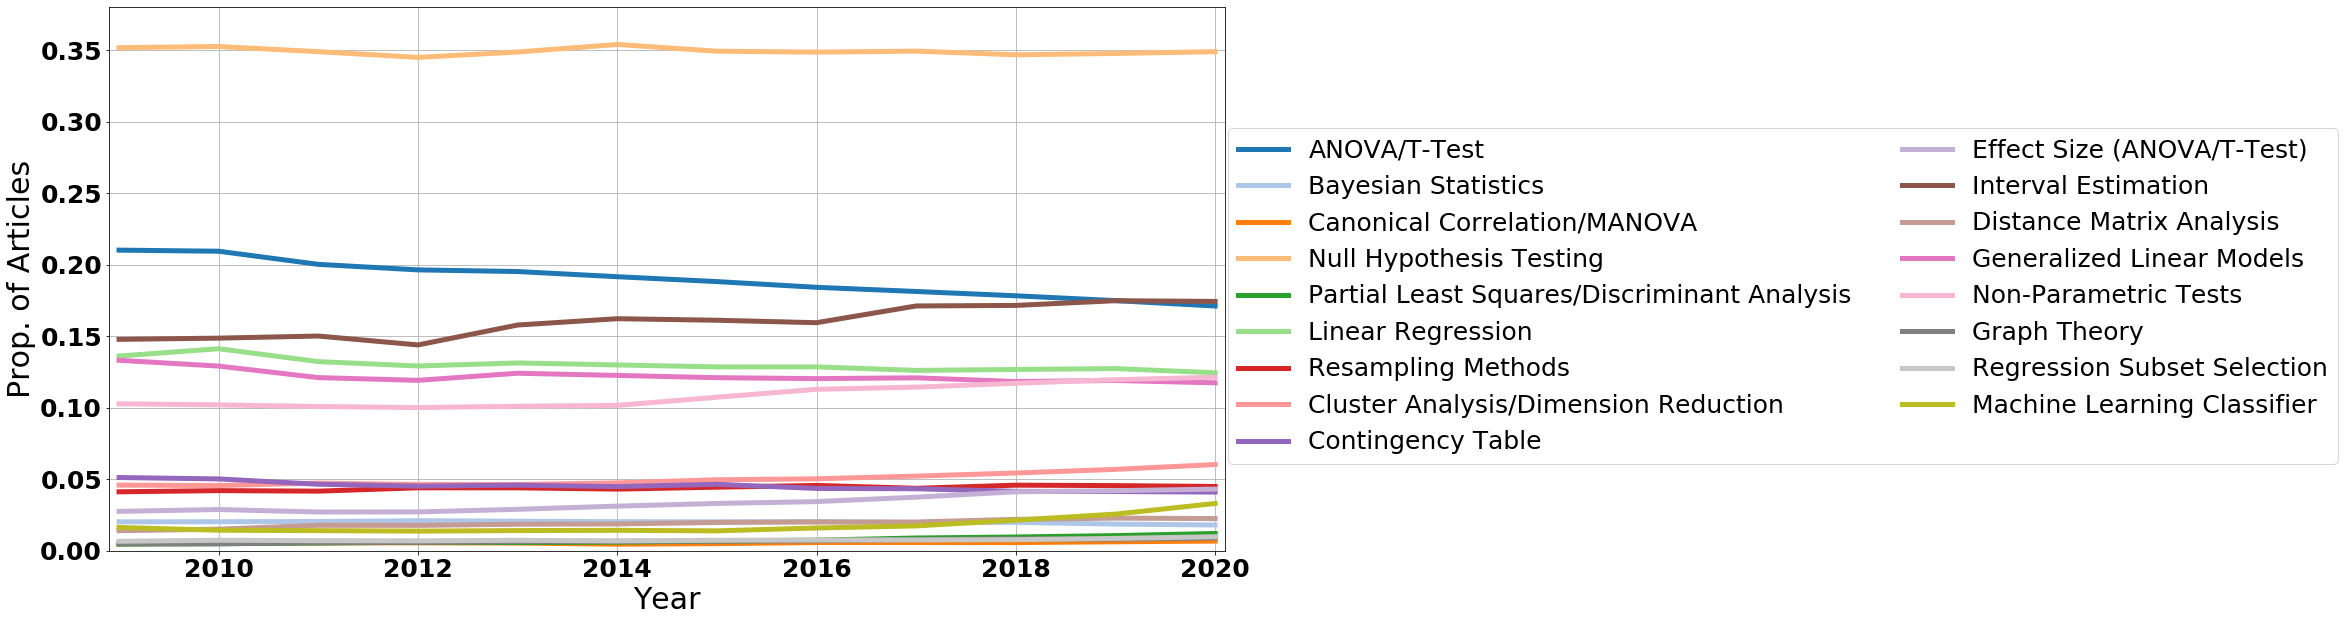

In [33]:
ent_select = ['anova_t_test', 'bayesian_statistics', 'cca_manova', 'null_hypothesis_testing', 
              'pls_da', 'linear_regression', 'resampling_methods', 
              'cluster_analysis_dimension_reduction', 'contingency_table', 'effect_size', 
              'interval_estimation', 'distance_matrix_analysis', 'generalized_linear_model', 
              'non_parametric_statistics_normality_test', 'graph_theory', 
              'subset_selection_regression', 'machine_learning']
stats_labels = ['ANOVA/T-Test', 'Bayesian Statistics', 'Canonical Correlation/MANOVA',
               'Null Hypothesis Testing', 'Partial Least Squares/Discriminant Analysis', 'Linear Regression',
               'Resampling Methods', 'Cluster Analysis/Dimension Reduction', 'Contingency Table', 
               'Effect Size (ANOVA/T-Test)', 'Interval Estimation', 'Distance Matrix Analysis', 
               'Generalized Linear Models', 'Non-Parametric Tests', 'Graph Theory', 
               'Regression Subset Selection', 'Machine Learning Classifier']
tab20_cmap = plt.get_cmap('tab20')
color_dict = {ent: tab20_cmap(i) for i, ent in enumerate(ent_select)}
resampled_df = ent_trends.entity_ts(df_analysis[ent_select], df_analysis['year'])

fig, ax = plt.subplots(figsize=(20,10))
for ent, label in zip(ent_select, stats_labels):
    ax.plot(resampled_df[ent], label=label, color=color_dict[ent], linewidth=5)
    
plt.yticks(fontweight='bold', fontsize=25)
plt.xticks(fontweight='bold', fontsize=25)
ax.set_ylabel('Prop. of Articles', fontsize=30)
ax.set_xlabel('Year', fontsize=30)
ax.grid(True)
plt.ylim(0, 0.38)
plt.xlim(2008.9,2020.1)
leg = plt.legend(labels=stats_labels, fontsize=25, ncol=2, loc='upper center', bbox_to_anchor=(1, 0, 1, 0.8))
for line in leg.get_lines():
    line.set_linewidth(5.0)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/All_TS.png', bbox_inches='tight')


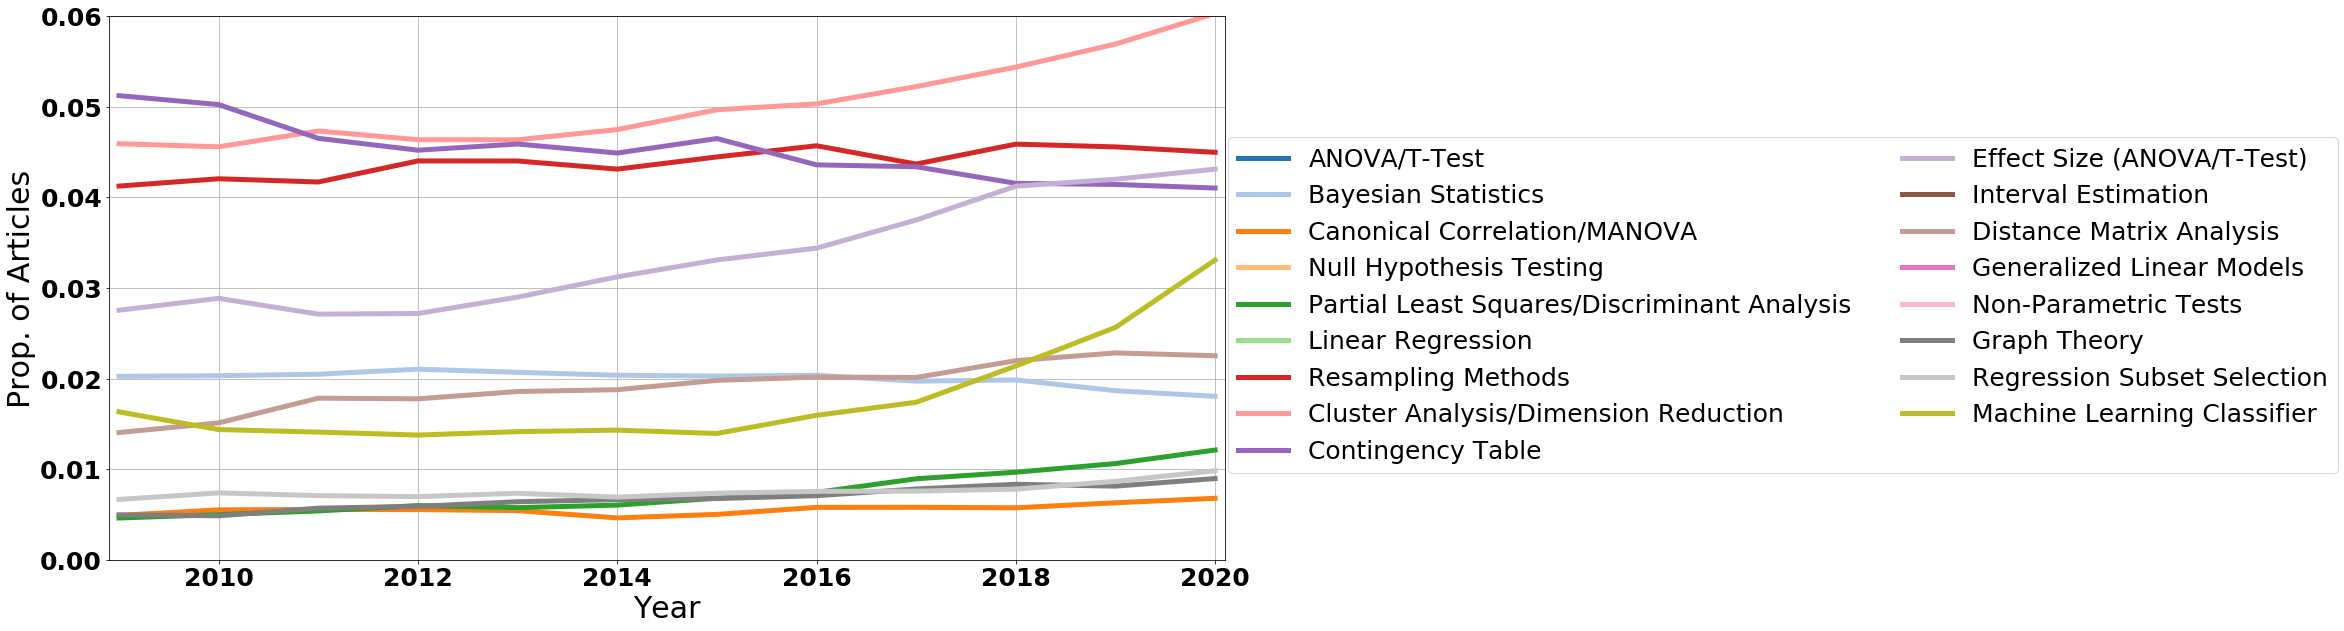

In [35]:
fig, ax = plt.subplots(figsize=(20,10))
for ent, label in zip(ent_select, stats_labels):
    ax.plot(resampled_df[ent], label=label, color=color_dict[ent], linewidth=5)
    
plt.yticks(fontweight='bold', fontsize=25)
plt.xticks(fontweight='bold', fontsize=25)
ax.set_ylabel('Prop. of Articles', fontsize=30)
ax.set_xlabel('Year', fontsize=30)
ax.grid(True)
plt.xlim(2008.9,2020.1)
plt.ylim(0, 0.06)
leg = plt.legend(labels=stats_labels, fontsize=25, ncol=2, loc='upper center', bbox_to_anchor=(1, 0, 1, 0.8))
for line in leg.get_lines():
    line.set_linewidth(5.0)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/All_TS_subset.png', bbox_inches='tight') # change ylim

## 2.3 Individual entity trend visualization

In [ ]:
# Create color mapping dictionary for domain
tab20_cmap = plt.get_cmap('tab20')
color_dict = {ent: tab20_cmap(i) for i, ent in enumerate(df_analysis.domain.unique())}

In [ ]:
ent_select = ['anova_t_test', 'bayesian_statistics', 'cca_manova', 'null_hypothesis_testing', 
              'pls_da', 'linear_regression', 'resampling_methods', 
              'cluster_analysis_dimension_reduction', 'contingency_table', 'effect_size', 
              'interval_estimation', 'distance_matrix_analysis', 'generalized_linear_model', 
              'non_parametric_statistics_normality_test', 'graph_theory', 
              'subset_selection_regression', 'machine_learning']

### ANOVA/T-Test

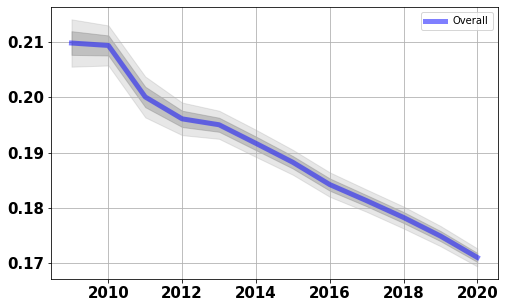

In [80]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'anova_t_test', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_anova.png', bbox_inches='tight')


### Linear Regression

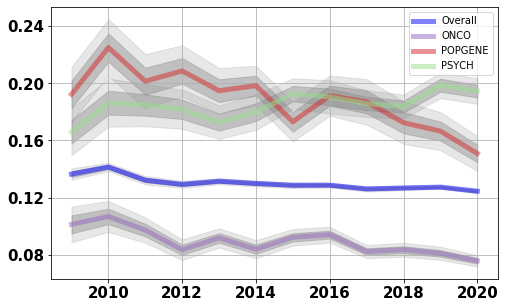

In [39]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'linear_regression', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_regression.png', bbox_inches='tight')

### Generalized Linear Models

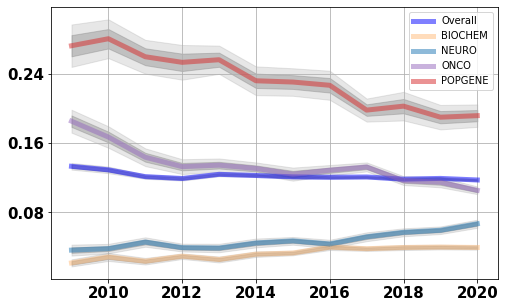

In [40]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'generalized_linear_model', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_gilm.png', bbox_inches='tight')

### Machine Learning

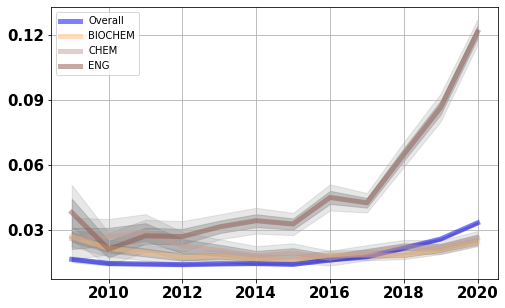

In [41]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'machine_learning', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_machine_learning.png', bbox_inches='tight')

### Cluster Analysis/Dimension Reduction

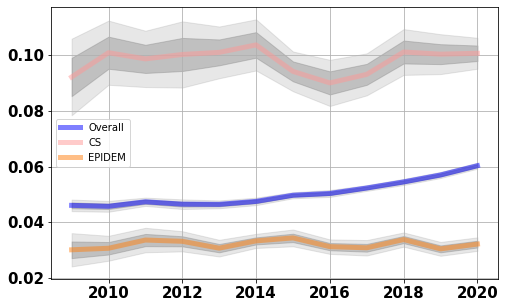

In [43]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'cluster_analysis_dimension_reduction', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_cluster.png', bbox_inches='tight')

### Bayesian Statistics

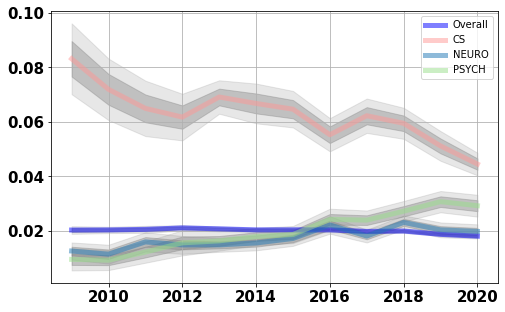

In [44]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'bayesian_statistics', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_bayesian.png', bbox_inches='tight')

### Partial Least Squares/Discriminant Analysis

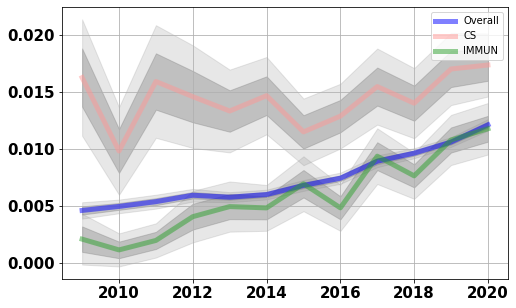

In [45]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'pls_da', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_plsda.png', bbox_inches='tight')

### Factor Analysis

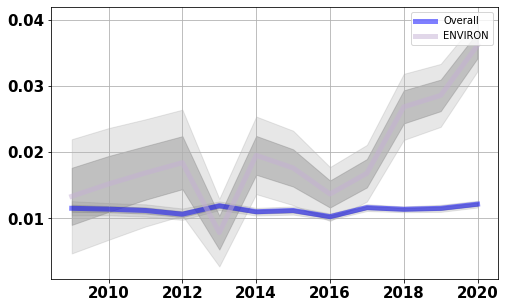

In [46]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'factor_analysis', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_factor_analysis.png', bbox_inches='tight')

### Graph Theory

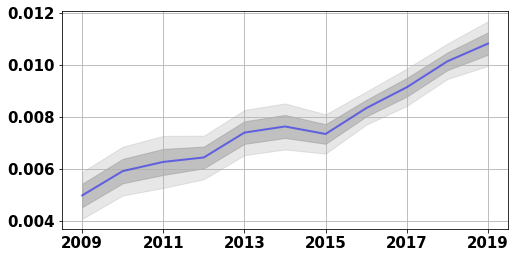

In [96]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'graph theory', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_graph_theory.png', bbox_inches='tight')

### Contigency Table

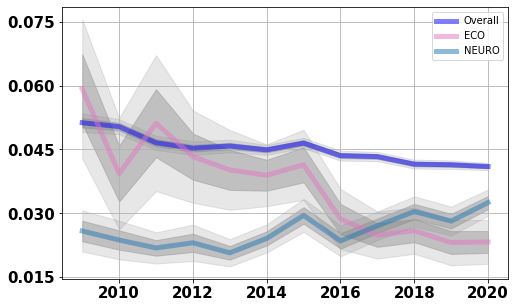

In [48]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'contingency_table', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_contingency_table.png', bbox_inches='tight')

### Resampling methods

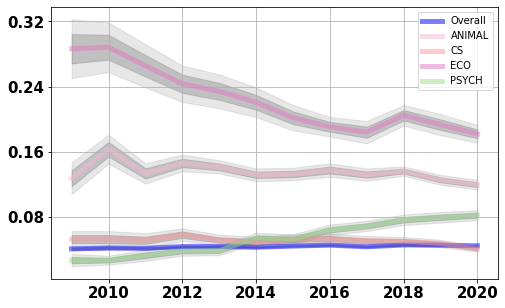

In [49]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'resampling_methods', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_resampling.png', bbox_inches='tight')

### Classification Accuracy

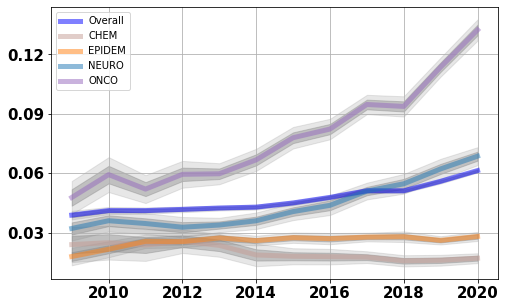

In [50]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'classification_accuracy', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_classification_acc.png', bbox_inches='tight')

### Interval Estimation

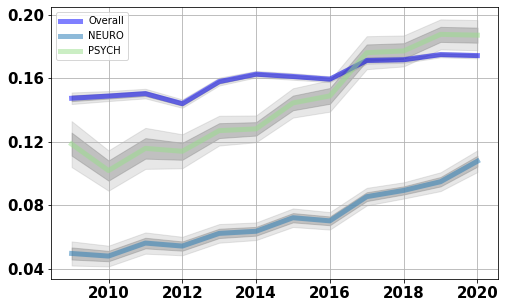

In [51]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'interval_estimation', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_interval_estimation.png', bbox_inches='tight')

### Effect Size (Anova/T-Test)

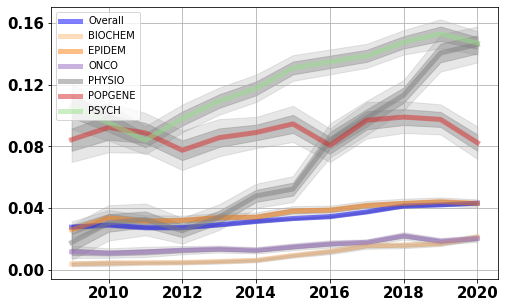

In [52]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'effect_size', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_effect_size.png', bbox_inches='tight')

### Fixed, Random & Multilevel Models

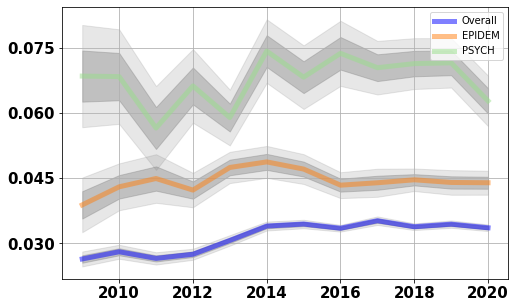

In [53]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'fixed_random_multilevel_model', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_multilevel.png', bbox_inches='tight')

### Thematic Analysis

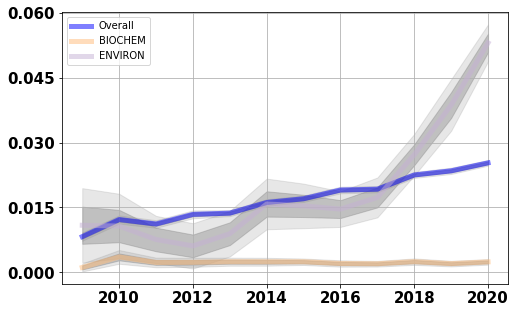

In [54]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'thematic_analysis', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_thematic_analysis.png', bbox_inches='tight')

### Meta Analysis

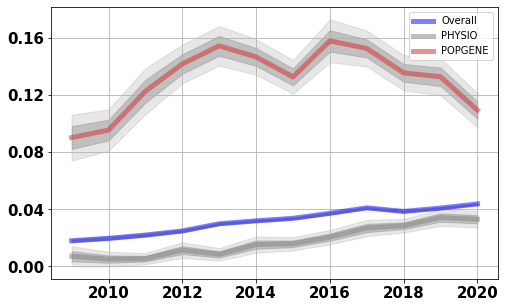

In [55]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'meta_analysis', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_meta_analysis.png', bbox_inches='tight')

### Survival Analysis

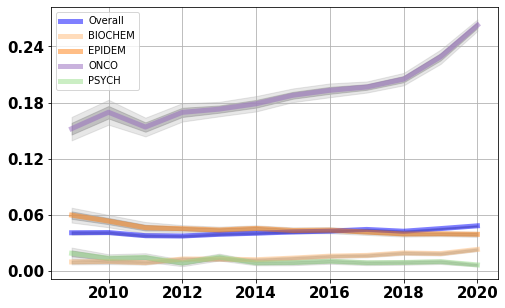

In [56]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'survival_analysis', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_survival.png', bbox_inches='tight')

### Non Parametric Statistics

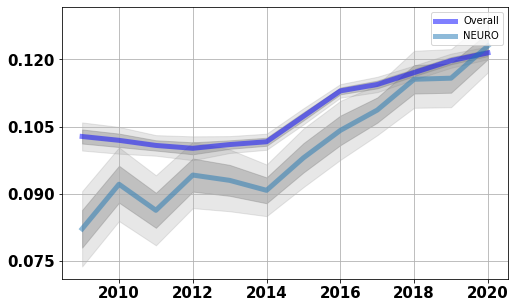

In [57]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'non_parametric_statistics_normality_test', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_non_parametric.png', bbox_inches='tight')

### Monte Carlo Method

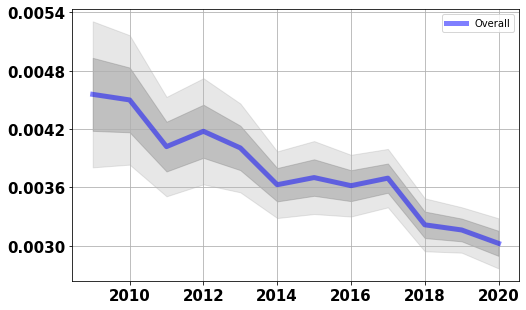

In [58]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'monte_carlo_method', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_monte_carlo.png', bbox_inches='tight')

### Null Hypothesis Testing

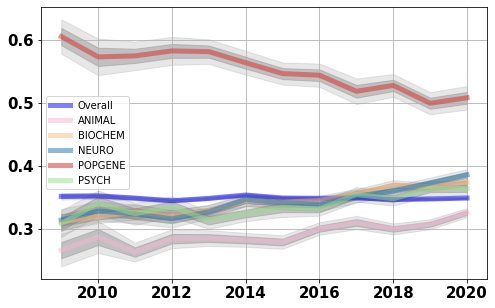

In [59]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'null_hypothesis_testing', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_null_hypothesis.png', bbox_inches='tight')

### Structural Equation Modeling

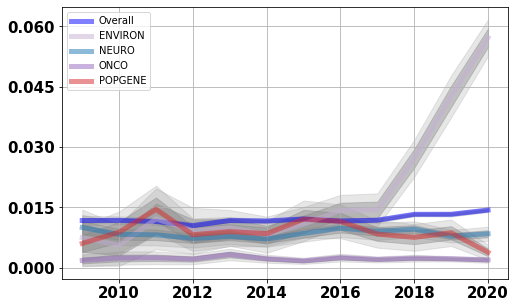

In [61]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'structural_equation_modeling', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_sem.png', bbox_inches='tight')

### Distance Matrix Analysis

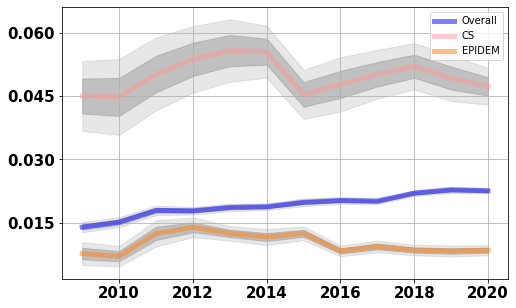

In [62]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'distance_matrix_analysis', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_dist_mat.png', bbox_inches='tight')

### Geostatistics (e.g., Kriging)

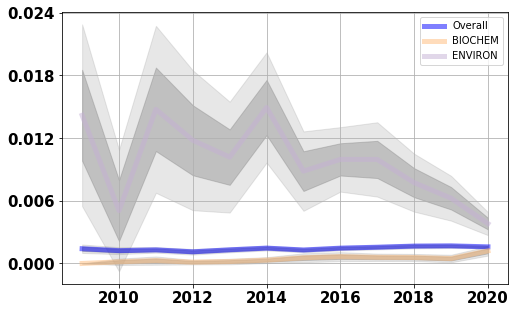

In [65]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'geostatistics', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_geo.png', bbox_inches='tight')

### CCA/MANOVA

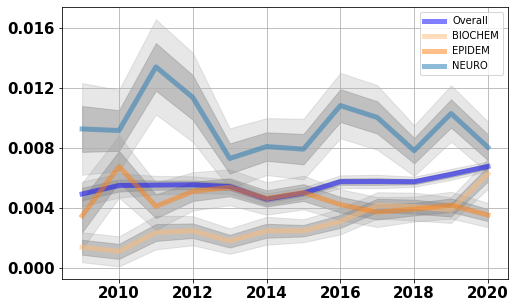

In [66]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'cca_manova', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_cca_manova.png', bbox_inches='tight')

### Regression Subset Selection

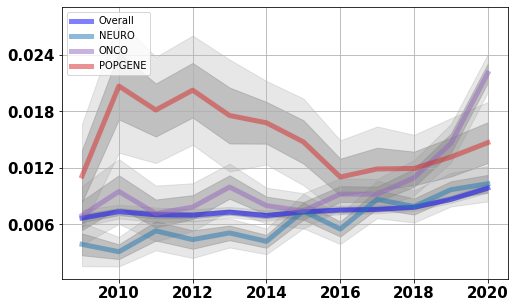

In [69]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'subset_selection_regression', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_regression_subset.png', bbox_inches='tight')

### Statistical Estimation

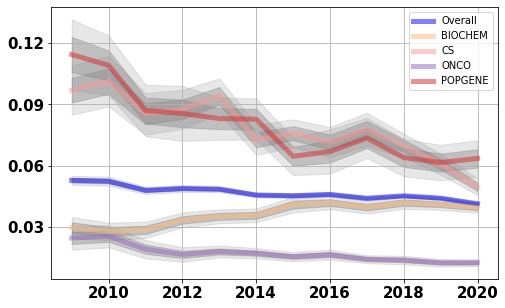

In [70]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'statistical_estimation', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_estimation.png', bbox_inches='tight')

### Bioinformatics Algorithms

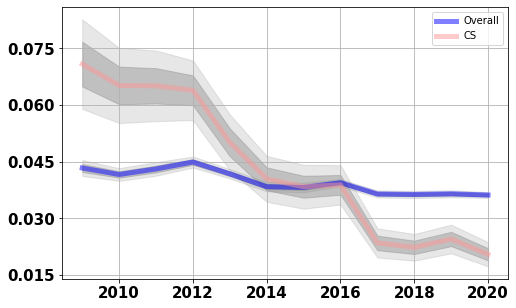

In [71]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'bioinformatics', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_bioinformatics.png', bbox_inches='tight')

### Model Comparison

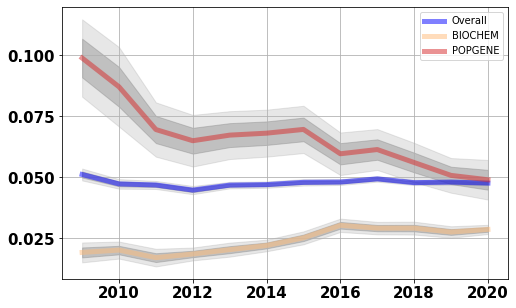

In [73]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'model_comparison', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_model_comparison.png', bbox_inches='tight')

### Time-Series/Signal Processing

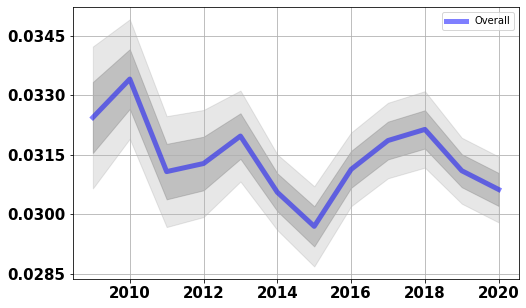

In [74]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'time_series_signal_processing', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_signal_processing.png', bbox_inches='tight')

### Graphical Plots

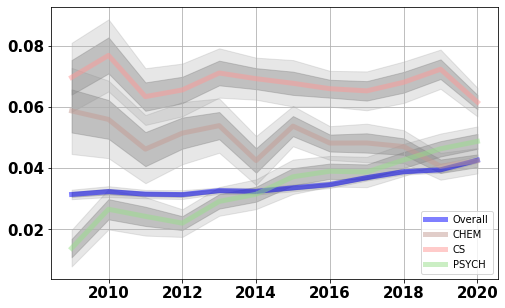

In [76]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'plot', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_plots.png', bbox_inches='tight')

### Multiple Comparison Correction

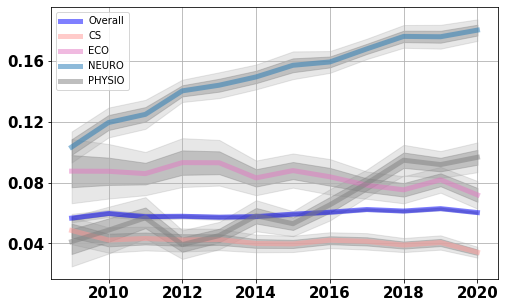

In [77]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'multiple_comparisons_correction', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_multiple_comparison.png', bbox_inches='tight')

### Information Theory

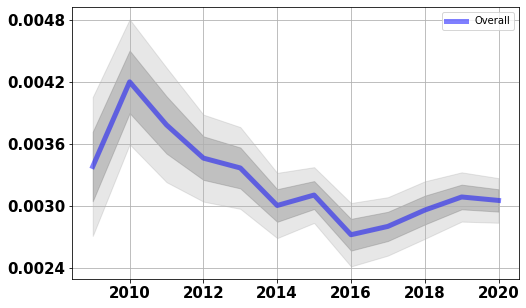

In [79]:
fig, ax = plt.subplots(figsize=(8,5))
plot_ts_group(df_analysis, 'information_theory', ax, color_dict)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure3/TS_information_theory.png', bbox_inches='tight')

# 3. Entity Domain by Method Analysis

## 3.1. Intiialize and Preprocess

### 3.1.1 Load and Intiliaze 'EntityDomain' Object

In [19]:
from analysis_main.ents_domain import EntityDomain
ent_classification = pd.read_csv('analysis_main/ent_classification.csv')
ent_classification_l1 = ent_classification.loc[~ent_classification.classification.isna(), :].copy()
ent_grouper_l1 = {ent: group for ent, group in 
                  zip(ent_classification_l1['ents'], ent_classification_l1['classification'])}
ent_domain = EntityDomain('results/ents/article_ents_final.pickle', 
                          ent_grouper=ent_grouper_l1, 
                          year_range=(2009, 2020))
df, additional_df = ent_domain.convert_to_dataframe(['domain', 'year', 'date', 'journal'])

## 3.2. Contingency Table Analysis

In this section, we examine the counts of analytic method mentions across domains to assess where analytic method entities are more likely to be mentioned by one domain vs. others. We used a contingency table approach (analytic method * domain) and standardized (Pearson) residuals to detect those analytic methods mentioned by one domain vs. others.

### 3.2.1 Get Domain by Method Entity contingency table

In [20]:
contingency_table = ent_domain.contingency_table(df, additional_df['domain'])

In [27]:
additional_df.domain.unique()

array(['NEURO', 'CLINIC', 'EPIDEM', 'BIOCHEM', 'IMMUN', 'PSYCH',
       'POPGENE', 'CS', 'ONCO', 'ENVIRON', 'ENG', 'CHEM', 'ECO', 'ANIMAL',
       'PHYSIO'], dtype=object)

### 3.2.2 Visualize top method entities for each discipline

In [34]:
domain = 'POPGENE'
contingency_table.standardized_resids.loc[domain].sort_values(ascending=False)[:10]

manhattan plot                     79.619433
meta analysis                      65.990959
multiple comparisons correction    58.157325
statistical power                  37.211791
fixed effect model                 36.537174
type i error                       32.742765
logistic regression                32.272588
effect size                        30.278408
qq plot                            29.165168
linkage disequilibrium plot        28.518908
Name: POPGENE, dtype: float64

# 4. Tensor Decomposition Analysis (i.e. 'Method Family' Analysis)

In this analysis, we aimed to detect *groupings* of analytic method entities that are the commonly mentioned together in research articles across one or more domains. We refer to these groupings as 'method families'. Method families are estimated from a tensor decomposition of a 3-dimensional matrix (tensor) formed by concatenating the 2-dimensional analytic method * analytic method (log-transformed) co-occurrence matrix for all domains. This 3-dimensional tensor represents the co-occurence of analytic method mentions within the research articles of each domain. Tensor (PARAFAC) decomposition of this 3-dimensional tensor produces a set of N components, or method families, with weights for each domain and analytic method. 

## 4.1. Initialize and Preprocess

### 4.1.1 Load and Intiliaze 'EntityNetwork' Object

In [2]:
from analysis_main.ents_network import EntityNetwork
ent_classification = pd.read_csv('analysis_main/ent_classification.csv')
ent_classification_l1 = ent_classification.loc[~ent_classification.classification.isna(), :].copy()
ent_grouper_l1 = {ent: group for ent, group in 
                  zip(ent_classification_l1['ents'], ent_classification_l1['classification'])}
ent_network = EntityNetwork('results/ents/article_ents_final.pickle', 
                            ent_grouper=ent_grouper_l1, 
                            year_range=(2009, 2020))
df, additional_df = ent_network.convert_to_dataframe(['domain', 'year', 'date', 'journal'])

## 4.2. Tensor Decomposition

In [3]:
word_count_mat = sp.csr_matrix(df.values)
networks = ent_network.compute_network_by_domain(word_count_mat, additional_df['domain'])
ent_network.tensor_decomp(networks, 21)

## 4.3. Plot Tensors

<ipython-input-6-c78f5598b7f0>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1,2,figsize=(12,7))


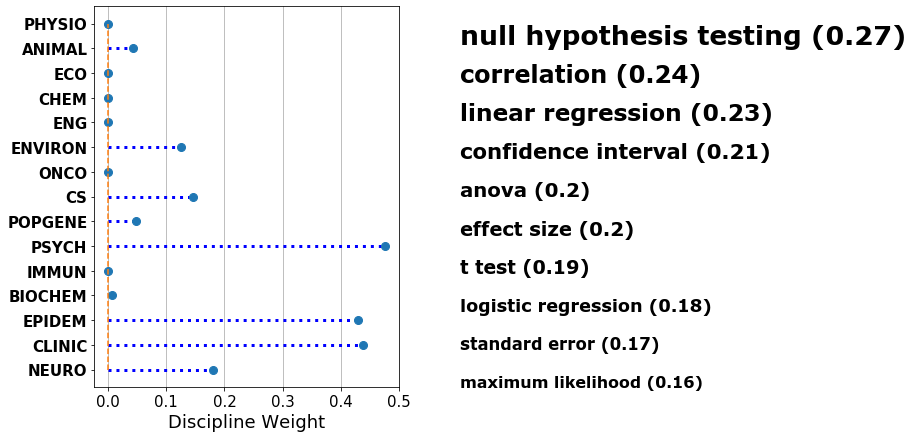

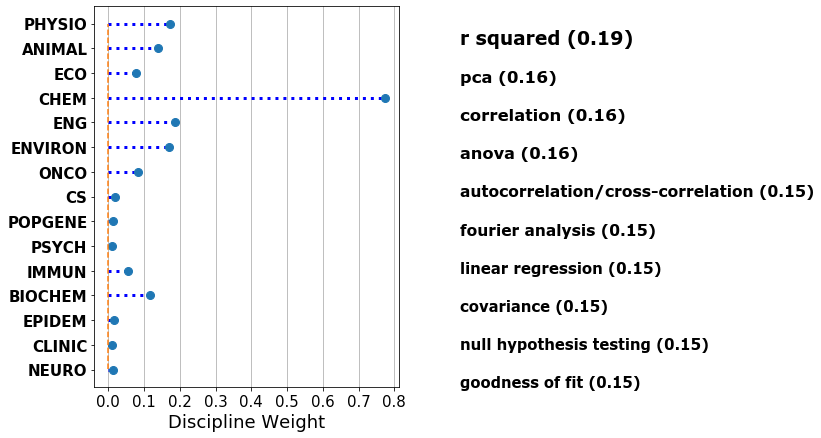

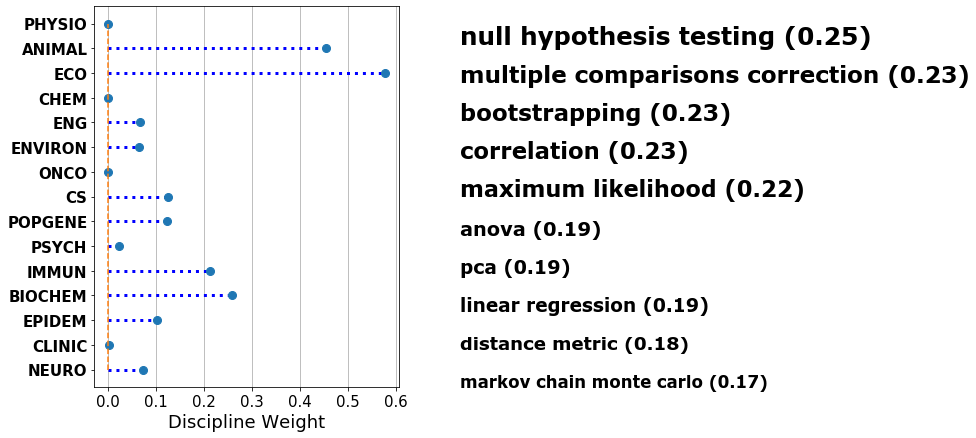

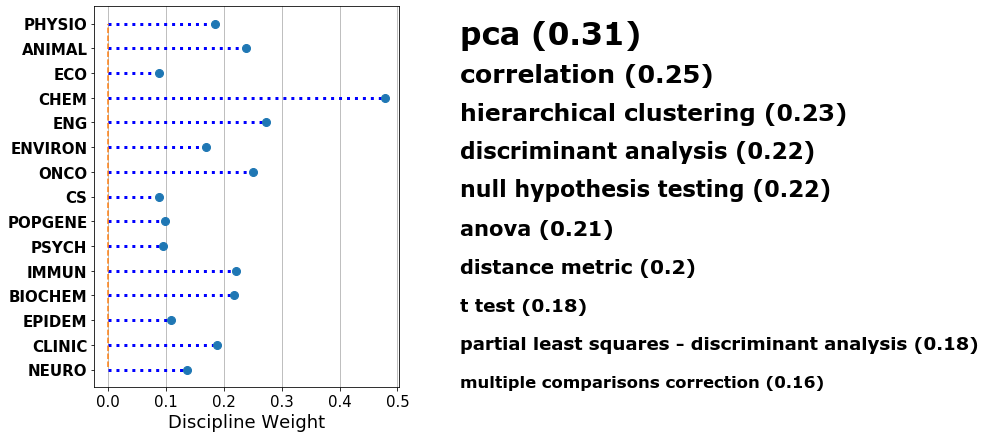

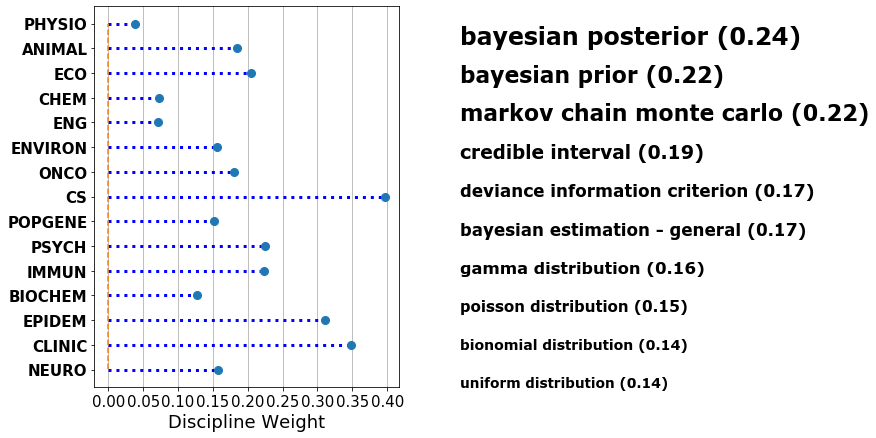

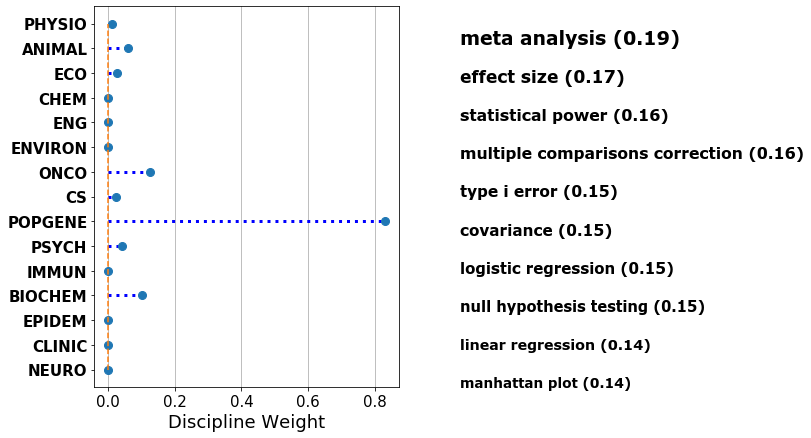

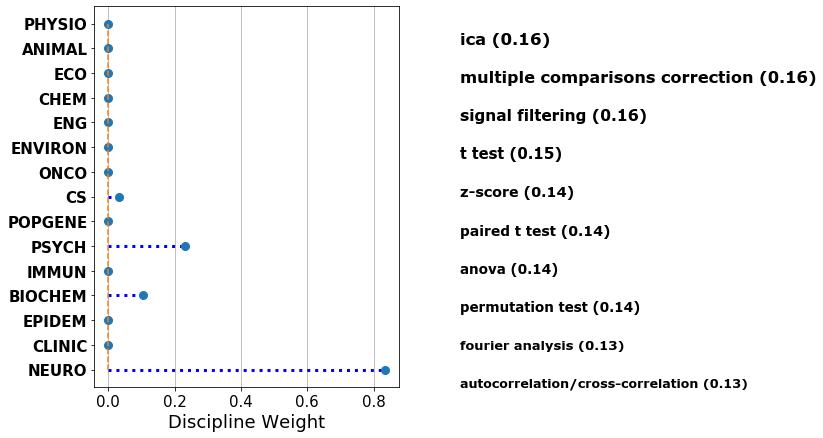

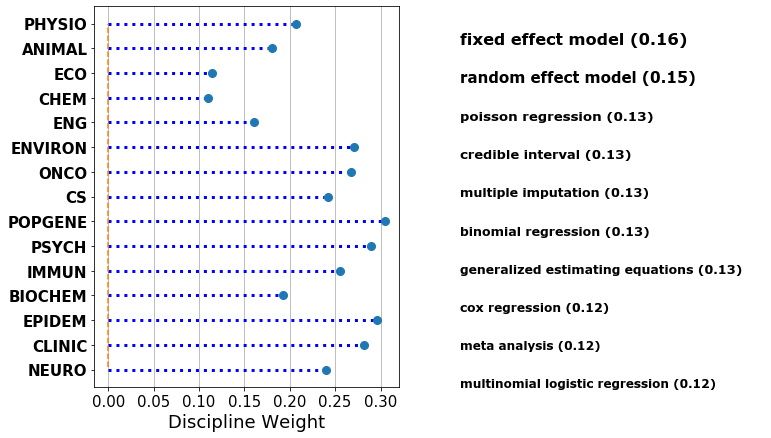

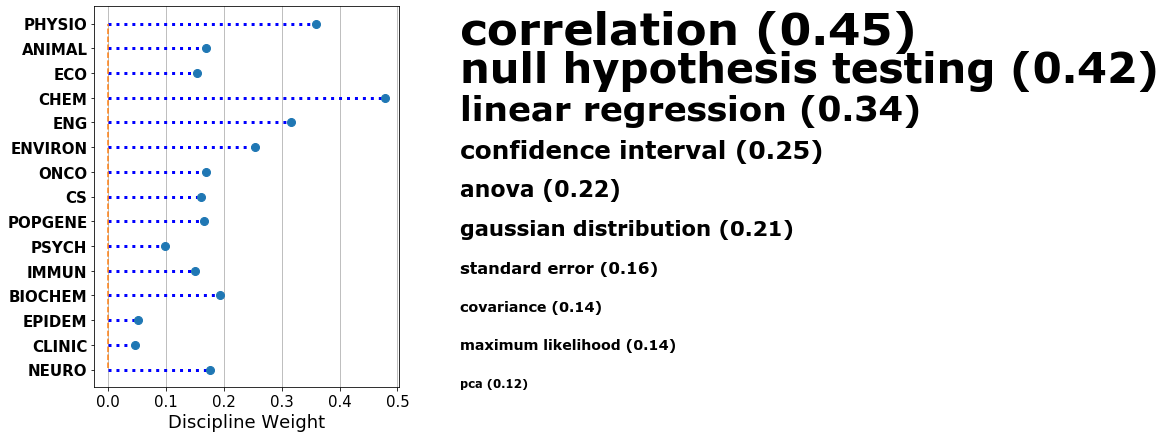

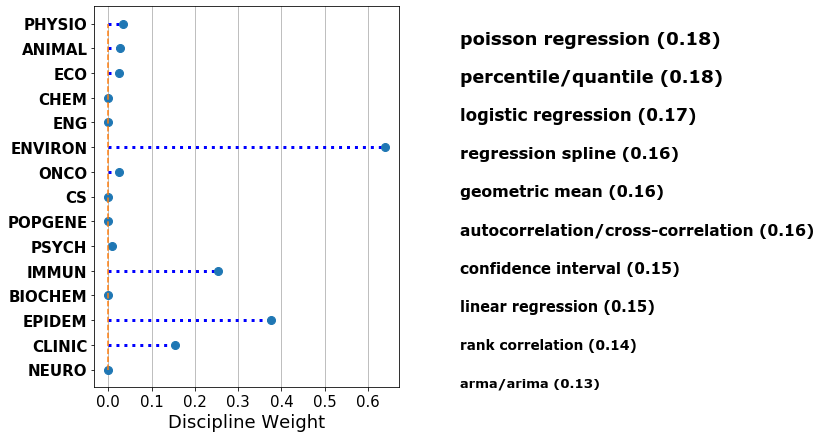

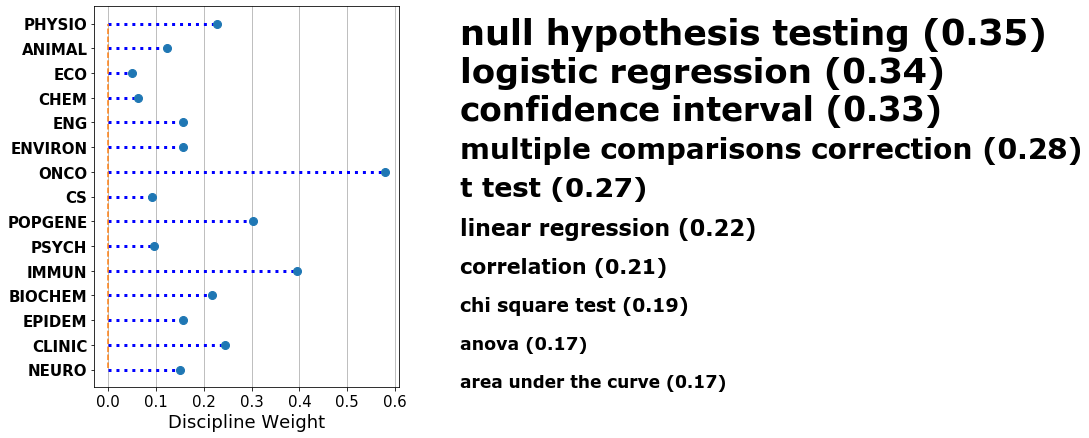

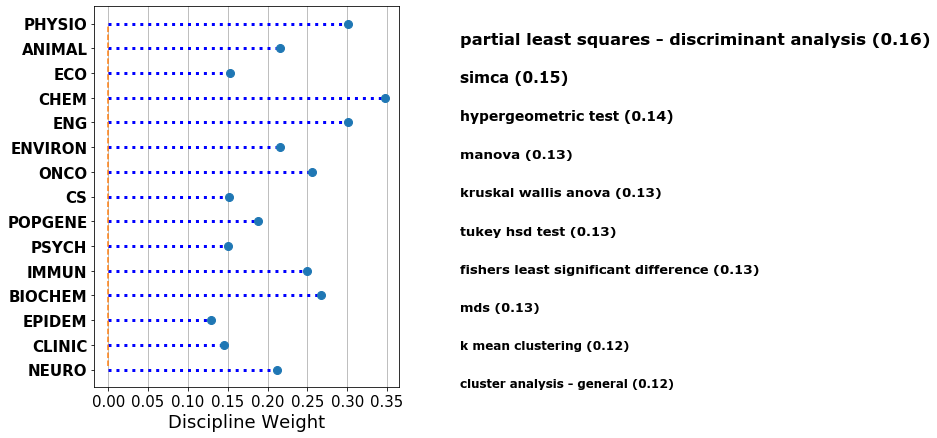

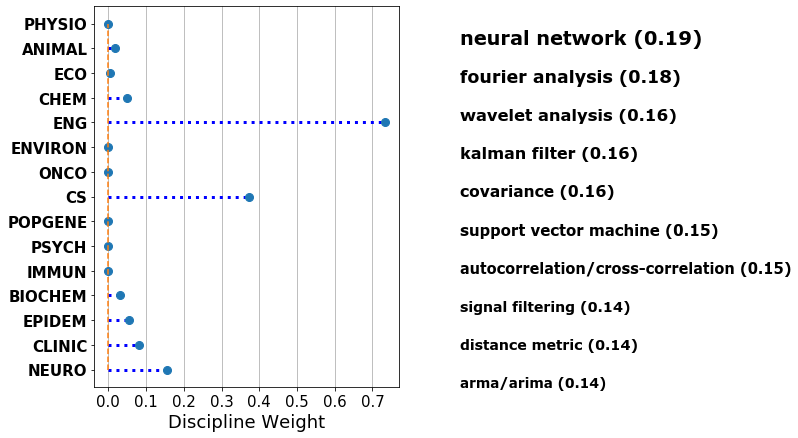

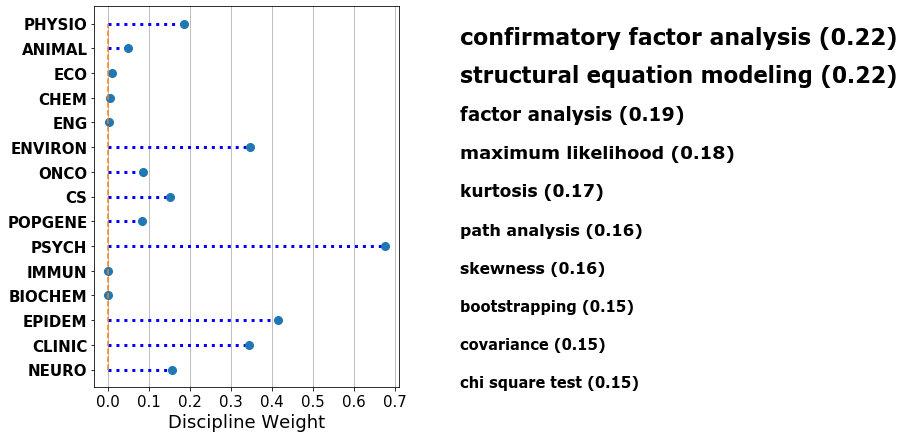

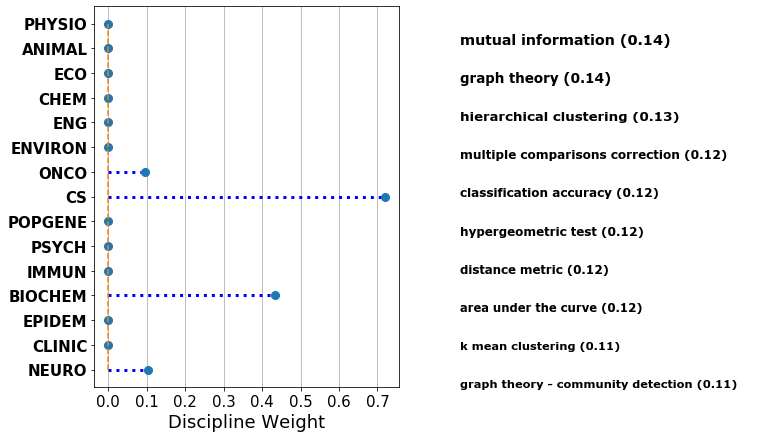

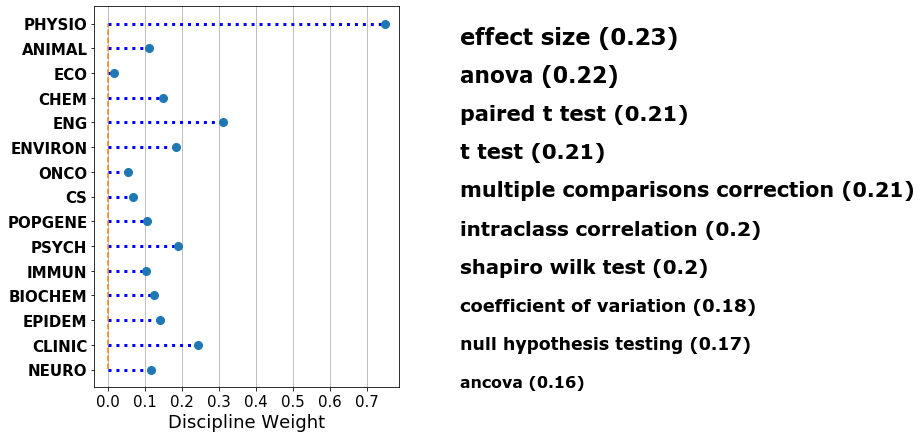

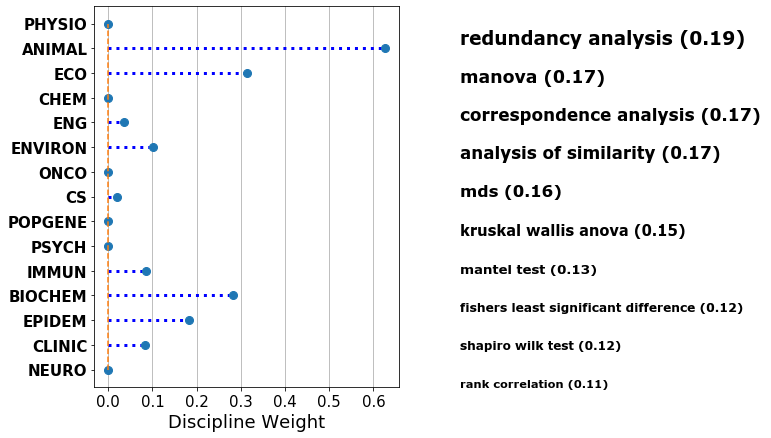

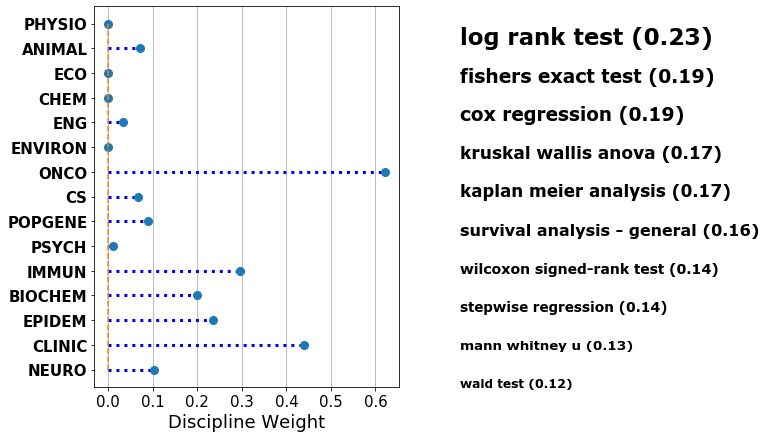

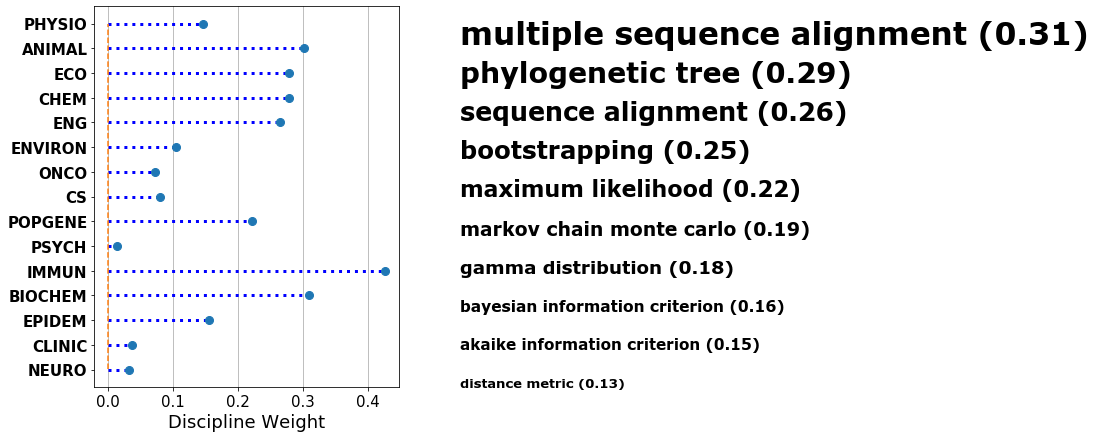

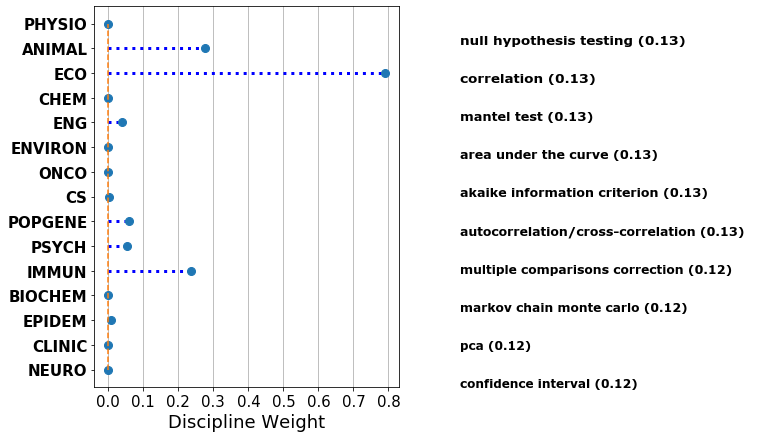

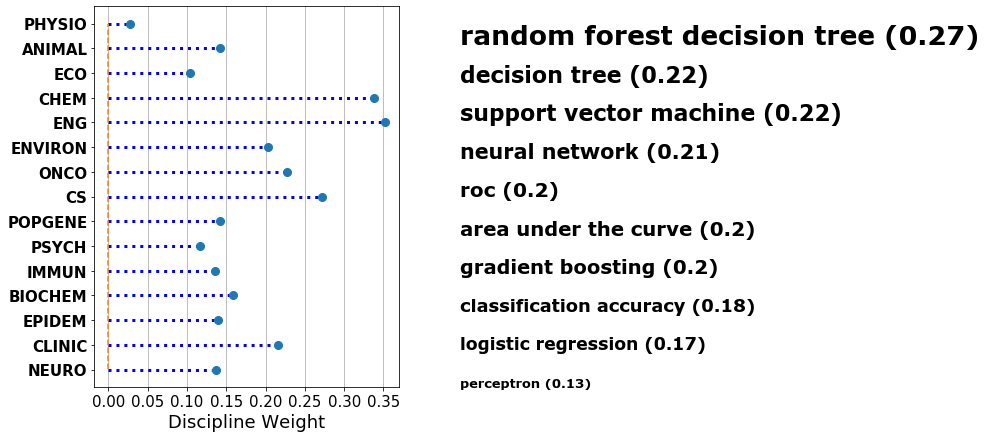

In [6]:
for comp in range(21):
    fig, axs = plt.subplots(1,2,figsize=(12,7))
    domain_weights = ent_network.factors[2][:,comp]
    ent_weights = ent_network.factors[0][:,comp]
    top10_indx = np.flip(ent_weights.argsort())[:10]
    axs[0].hlines(np.arange(15), 0, domain_weights, color='blue', linestyles=':', linewidth=3)  # Stems
    axs[0].plot(domain_weights, np.arange(15), 'o', markersize=8)  # Stem ends
    axs[0].plot([0, 0], [domain_weights.min(), np.arange(15).max()], '--')  # Middle bar
    plt.sca(axs[0])
    plt.yticks(np.arange(15), ent_network.network_domains, size=15, weight='bold')
    plt.xticks(size=15)
    plt.grid(axis='x')
    plt.xlabel('Discipline Weight', fontsize=18)
    y = 1
    for indx in top10_indx:
        size = ent_weights[indx]
        label = ent_network.id2voc[indx] + f' ({round(size,2)})'
        y -= 0.1
        axs[1].text(0, y, label, fontsize=size*100, fontweight='bold', family='Verdana')
    axs[1].axis('off')
    plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Figure6/Comp_Weights/C21/Comp_{comp}.png', bbox_inches='tight')

# 5. Supplementary Analyses

## 5.1 Data-Driven Analysis of Entity Trends

### 5.1.1 Define Plotting Function

In [4]:
def plot_sorted_corr_mat(corr_mat, cluster_assignments, ax):
    # Create sorting index from factor assignments
    sort_indx = np.argsort(cluster_assignments)
    sorted_vals = np.sort(cluster_assignments)
    # Sort Distance Matrix
    sortedmat = [[corr_mat[i][j] for j in sort_indx] for i in sort_indx]
    # Plot Distance Matrix
    c = ax.pcolormesh(sortedmat, cmap='coolwarm')
    plt.colorbar(c, ax=ax, fraction=0.03)
    # Plot rectangular patches along diagnol to indicate factor assignments
    for i in np.unique(sorted_vals):
        ind = np.where(sorted_vals == i)
        mn = np.min(ind)
        mx = np.max(ind)
        sz=(mx-mn)+1
        rect = Rectangle((mn,mn), sz, sz , linewidth=1, 
                         edgecolor='black', facecolor='none')
        ax.add_patch(rect)

### 5.1.2 Run cluster analysis of temporal trends
* An arbitrary cluster number was chosen (N=3) that approximately separated analytic methods with a negative, positive and flat (slightly curvilinear) trend.

In [2]:
from analysis_main.ents_trends import EntityTrends
ent_classification = pd.read_csv('analysis_main/ent_classification.csv')
ent_classification_l1 = ent_classification.loc[~ent_classification.classification.isna(), :].copy()
ent_grouper_l1 = {ent: group for ent, group in 
                  zip(ent_classification_l1['ents'], ent_classification_l1['classification'])}
ent_trends = EntityTrends('results/ents/article_ents_final.pickle', 
                      ent_grouper=ent_grouper_l1, 
                      year_range=(2009, 2020))
df, additional_df = ent_trends.convert_to_dataframe(['domain', 'year', 'date', 'journal'])

# Calculate entity counts by year for each analytic method
ent_ts = []
for ent in df.columns:
    ent_ts.append(ent_trends.entity_count_by_time(df[[ent]], additional_df['year'], norm=False)) 
    
ent_df_ts = pd.concat(ent_ts, axis=1).div(additional_df.groupby('year').size(), axis=0)

# Cluster
pdist = spc.distance.pdist(ent_df_ts.values.T, 'correlation')
linkage = spc.linkage(pdist, method='ward')
idx = spc.fcluster(linkage,3,'maxclust')

### 5.1.3. Plot

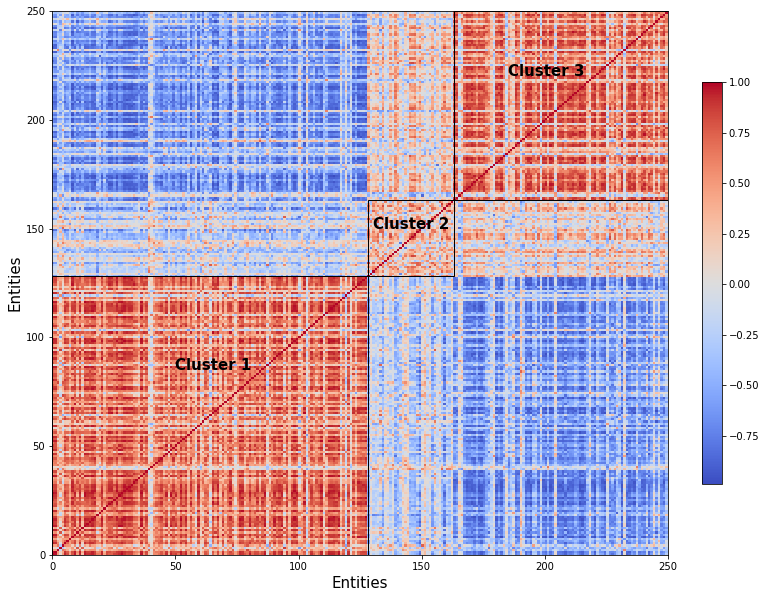

In [5]:
fig, ax = plt.subplots(figsize=(12,10))
corr_mat = ent_df_ts.corr().values
plot_sorted_corr_mat(corr_mat,idx, ax)
ax.set_xlabel('Entities', fontsize=15)
ax.set_ylabel('Entities', fontsize=15)
ax.text(50, 85, 'Cluster 1', fontsize=15, fontweight='bold')
ax.text(130, 150, 'Cluster 2', fontsize=15, fontweight='bold')
ax.text(185, 220, 'Cluster 3', fontsize=15, fontweight='bold')
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Supp_Figure1/FigA.png', bbox_inches='tight')
plt.show()

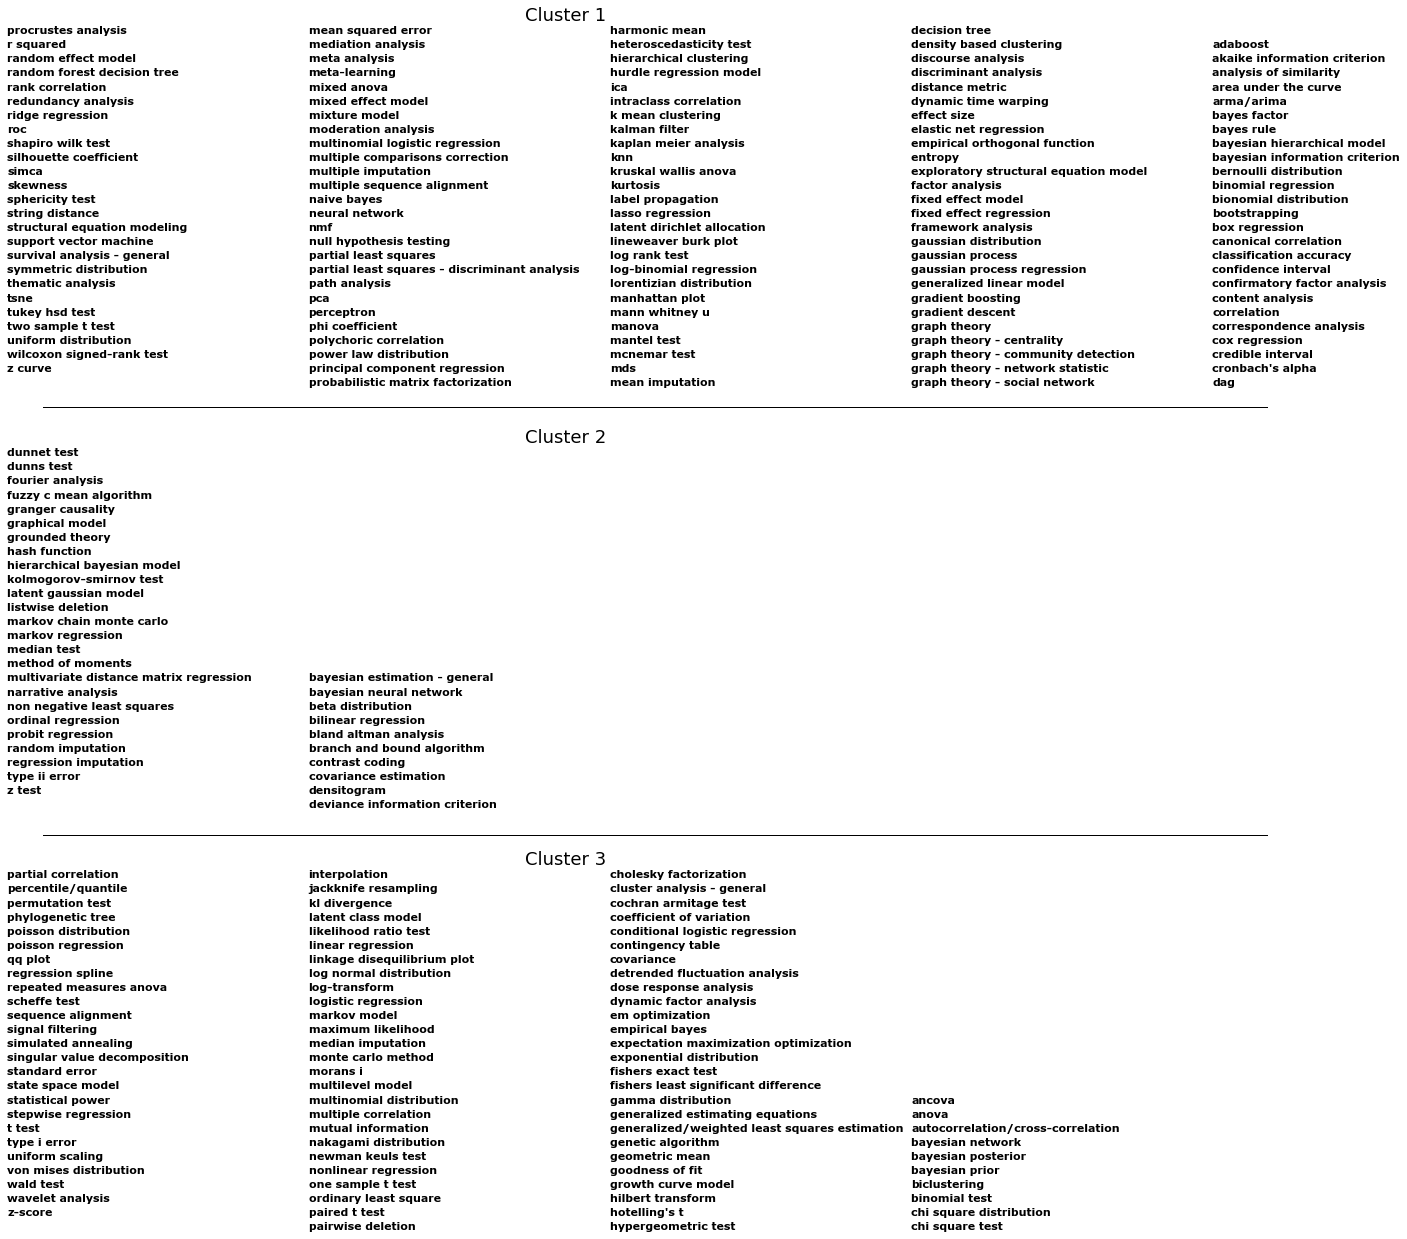

In [6]:
cols_array = np.array(df.columns)
fig, axs = plt.subplots(3,1,figsize=(20,22))
for i in range(3):
    c_indx = np.where(idx == (i+1))[0]
    break_indx=0
    y = 0
    for indx in c_indx[::-1]: 
        if (y % 25 == 0) & (y != 0):
            break_indx+=0.27
            y = 0
        else:
            y+=1
        axs[i].text(break_indx, (y/25)-0.02, cols_array[indx], fontsize=11, fontweight='bold', family='Verdana')
    axs[i].axis('off')
    axs[i].set_title(f'Cluster {i+1}', fontsize=18)
fig.patch.set_visible(False)
line = plt.Line2D((.15,1),(.37,.37), color="k", linewidth=1)
fig.add_artist(line)
line = plt.Line2D((.15,1),(.64,.64), color="k", linewidth=1)
fig.add_artist(line)
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Supp_Figure1/FigB.png', bbox_inches='tight')
plt.show()

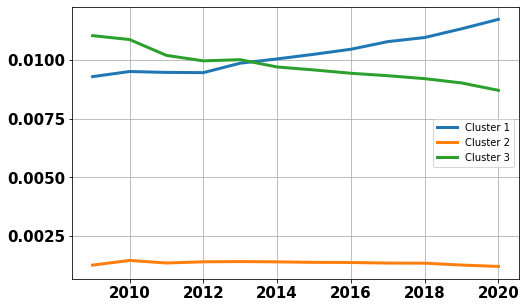

In [7]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(ent_df_ts.iloc[:, np.where(idx==1)[0]].mean(axis=1), label='Cluster 1', linewidth=3)
ax.plot(ent_df_ts.iloc[:, np.where(idx==2)[0]].mean(axis=1), label='Cluster 2', linewidth=3)
ax.plot(ent_df_ts.iloc[:, np.where(idx==3)[0]].mean(axis=1), label='Cluster 3', linewidth=3)
plt.yticks(fontweight='bold', fontsize=15)
plt.xticks([2010, 2012, 2014, 2016, 2018, 2020], 
          [2010, 2012, 2014, 2016, 2018, 2020], 
          fontweight='bold', fontsize=15)
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax.grid(True)
ax.legend()
plt.savefig(f'/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Supp_Figure1/FigC.png', bbox_inches='tight')


## 5.2 Table of Analytic Method Frequencies

In [8]:
from analysis_main.ents_base import EntityBase
ent_classification = pd.read_csv('analysis_main/ent_classification.csv')
ent_classification_l1 = ent_classification.loc[~ent_classification.classification.isna(), :].copy()
ent_grouper_l1 = {ent: group for ent, group in 
                  zip(ent_classification_l1['ents'], ent_classification_l1['classification'])}
ent_base = EntityBase('results/ents/article_ents_final.pickle', ent_grouper_l1, 
                      year_range=(2009, 2020))
df, additional_df = ent_base.convert_to_dataframe(['domain', 'year', 'date', 'journal'])

### 5.2.1 Raw Frequencies

In [9]:
df_pivot = df.groupby(additional_df['year']).sum().reset_index().T
df_pivot.columns = df_pivot.iloc[0,:]
df_pivot = df_pivot.drop(index='year')
df_pivot = df_pivot.reset_index()
df_pivot = df_pivot.rename(columns={'index': 'entity'})

In [11]:
df_pivot.to_csv('/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Supp_Table1/entity_counts.csv')

### 5.2.2 Percentages by Year

In [22]:
# Calculate entity counts by year for each analytic method
ent_ts = []
for ent in df.columns:
    ent_ts.append(ent_trends.entity_count_by_time(df[[ent]], additional_df['year'], norm=False)) 
    
ent_df_ts = pd.concat(ent_ts, axis=1).div(additional_df.groupby('year').size(), axis=0)

In [25]:
ent_df_ts.T.to_csv('/Users/taylorbolt/Desktop/Publishing/Stats_Mining/Figures/Supp_Table1/entity_counts_perc.csv')